# DelftaCalculator basics and $\Delta$-learning vs. direct learning 

In [3]:
import os
import glob
from openbabel.pybel import readfile, readstring
import numpy as np
from delfta.utils import TESTS_PATH, DATA_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [4]:
if not os.path.exists(os.path.join(TESTS_PATH)): 
    from delfta.download import TESTS_REMOTE, download
    import tarfile 
    
    download(TESTS_REMOTE, os.path.join(DATA_PATH, "test_data.tar.gz"))
    with tarfile.open(os.path.join(DATA_PATH, "test_data.tar.gz")) as handle:
        handle.extractall(DATA_PATH)

mol_files = glob.glob(os.path.join(TESTS_PATH, "mols_working", "CHEMBL*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value ($\omega$B97X-D/def2-SVP)) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [5]:
from delfta.calculator import DelftaCalculator

calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges", "wbo"], delta=True) 
# Verbose passing of arguments. We could've used "all" as well
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(delta=False) 
# the default setting (tasks=None) means the calculator will perform all calculations for all endpoints
predictions_direct = calc_direct.predict(mols)

2021/08/31 02:45:21 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 100/100 [00:17<00:00,  5.59it/s]
2021/08/31 02:45:39 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 100/100 [00:06<00:00, 15.40it/s]
2021/08/31 02:45:46 PM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 100/100 [00:00<00:00, 188.30it/s]
2021/08/31 02:45:46 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 100/100 [00:05<00:00, 17.05it/s]
2021/08/31 02:45:52 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 100/100 [00:06<00:00, 16.30it/s]
2021/08/31 02:45:58 PM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 100/100 [00:06<00:00, 15.77it/s]
2021/08/31 02:46:05 PM | DelFTa | INFO: Now running network for model wbo_direct...
100%|██████████| 100/100 [00:00<00:00, 260.95it/s]
2021/08/31 02:46:05 PM | DelFTa | INFO: Now running network

Let's put the output in a dataframe to get an overview: 

In [6]:
import pandas as pd

df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],wbo,E_form [Ha],charges [e]
0,CHEMBL3912963_conf_01.sdf,-0.263745,0.038267,0.302030,3.256681,"[1.0980873635774802, 1.0986835152601884, 1.079...",-11.174025,"[0.08720742602460861, -0.42964283333969117, 0...."
1,CHEMBL2348937_conf_01.sdf,-0.287757,-0.014009,0.273753,5.213440,"[1.074324330322692, 1.385471003209812, 2.23133...",-5.817765,"[0.12303730947250366, -0.3266444559584999, 0.2..."
2,CHEMBL1927423_conf_00.sdf,-0.275372,0.029717,0.305024,4.826956,"[1.3727940924078603, 1.637800615121199, 1.3662...",-5.892082,"[-0.07713254998229979, 0.16096720328565597, -0..."
3,CHEMBL2018019_conf_01.sdf,-0.276345,0.000457,0.276816,2.919992,"[1.297767185004958, 1.3325952364165294, 1.5229...",-11.250399,"[-0.10939113866821287, 0.007453082924728405, -..."
4,CHEMBL2178189_conf_01.sdf,-0.279830,0.032103,0.311955,8.375891,"[1.130377596903457, 1.257862860995099, 1.37960...",-10.878448,"[0.13880032371055603, -0.3524141993826866, 0.2..."
...,...,...,...,...,...,...,...,...
95,CHEMBL3234761_conf_02.sdf,-0.284742,0.016734,0.301408,5.687694,"[1.0252630547930592, 1.0267035841345993, 0.995...",-12.243986,"[0.008726551394748691, -0.09789766379543305, 0..."
96,CHEMBL3678060_conf_01.sdf,-0.328210,-0.013991,0.314256,6.511817,"[1.0444042382687517, 1.4248072883427665, 1.466...",-8.846279,"[0.05737841430717468, -0.10974226135429382, -0..."
97,CHEMBL1702692_conf_00.sdf,-0.278086,-0.029041,0.249053,6.529699,"[1.1211665539660696, 1.283248099471469, 1.3903...",-7.064505,"[0.13214325301073074, -0.33700465409694674, 0...."
98,CHEMBL2179517_conf_02.sdf,-0.311141,0.033468,0.344632,4.905161,"[2.1215248484645013, 0.9829546946704794, 1.417...",-5.392777,"[-0.27338701696395873, 0.23769020738583085, -0..."


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [7]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
predictions_delta["wbo"] = np.concatenate(predictions_delta["wbo"])
predictions_direct["wbo"] = np.concatenate(predictions_direct["wbo"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES", "DFT:WIBERG_LOWDIN_BOND_ORDER"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES" or dft_key == "DFT:WIBERG_LOWDIN_BOND_ORDER": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



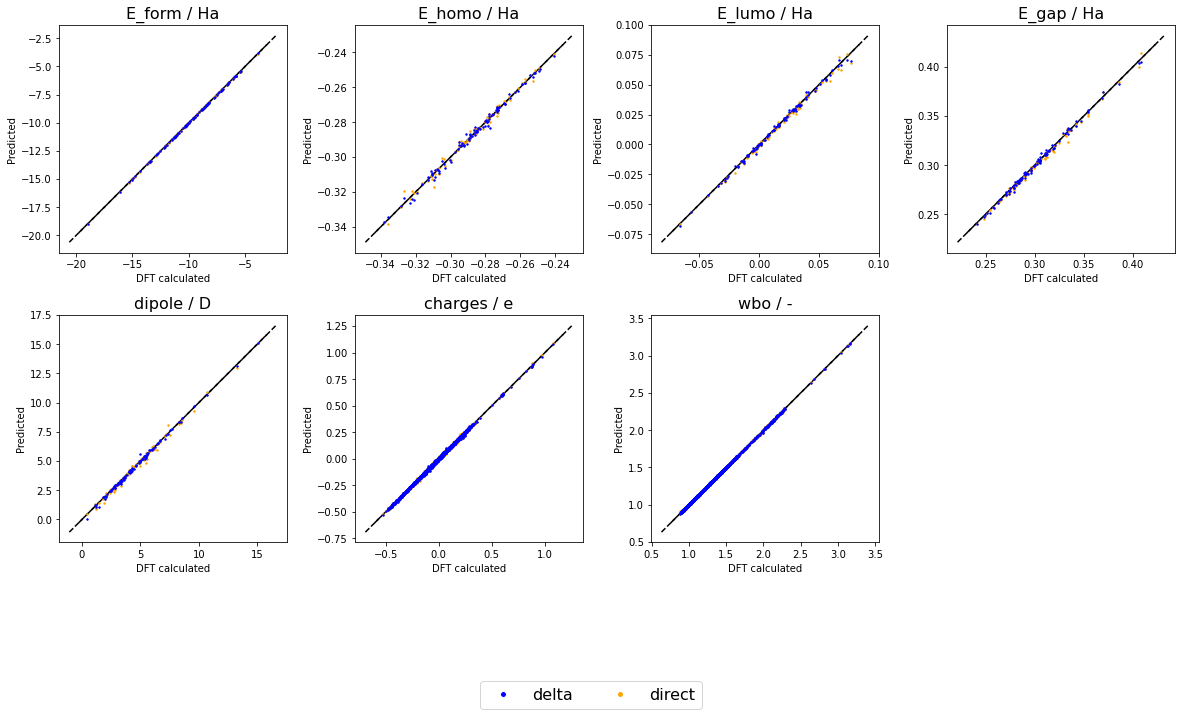

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def make_plot(ax, dft_vals, pred_vals, label, unit, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=2)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=4)
gs.update(wspace=0.3, hspace=-0.2)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges", "wbo"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e", "-"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]
for ax, pred_key, dft_key, unit in zip(axes, pred_keys, dft_keys, units): 
    make_plot(ax, dft_values[dft_key], predictions_direct[pred_key], pred_key, unit, "orange")
    make_plot(ax, dft_values[dft_key], predictions_delta[pred_key], pred_key, unit, "blue")
    ax.title.set_text(f"{pred_key} / {unit}")
    ax.title.set_fontsize(16)
axes[-1].axis("off")

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see, both $\Delta$- and direct-learning approximate the $\omega$B97X-D/def2-SVP ground truth well. Check our paper for a more detailed discussion.

You can also create molecules directly from SMILES. In that case, you need to keep `force3D=True` (the default), so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [9]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(delta=True, force3d=True)
preds_delta = calc.predict(mols)
print(preds_delta)

2021/08/31 02:46:24 PM | DelFTa | INFO: Assigned MMFF94 coordinates and added hydrogens to molecules at position(s) [0]
2021/08/31 02:46:24 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 1/1 [00:00<00:00, 14.30it/s]
2021/08/31 02:46:24 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 50.95it/s]
2021/08/31 02:46:24 PM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 1/1 [00:00<00:00, 82.90it/s]
2021/08/31 02:46:24 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 49.47it/s]
2021/08/31 02:46:24 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 20.57it/s]

{'E_homo': array([-0.34340343], dtype=float32), 'E_lumo': array([-0.0113354], dtype=float32), 'E_gap': array([0.33208168], dtype=float32), 'dipole': array([3.6183674], dtype=float32), 'wbo': [array([2.22127832, 1.06267219, 1.23924539, 1.15730829, 1.41330074,
       1.47810425, 1.46557587, 1.48721643, 1.39077188, 1.36936832,
       1.03561741, 2.14403422, 1.37116737, 0.92375936, 0.93466771,
       0.9550889 , 0.91969945, 0.9214961 , 0.9243923 , 0.91680812,
       1.07811207])], 'E_form': array([-3.8750796], dtype=float32), 'charges': [array([-0.19502236,  0.18486175, -0.09279293, -0.29193805,  0.20933141,
       -0.04123083,  0.01227743, -0.0027082 , -0.01238181, -0.10150234,
        0.19773265, -0.22955808, -0.19538686,  0.0688796 ,  0.08436467,
        0.07262717,  0.03356808,  0.03614845,  0.03038858,  0.04364362,
        0.21507574])]}
